This notebooks aims to compare plumes and wind calibration over different scenes.

In [1]:
import xarray as xr
from matplotlib import rcParams
import geopandas as gpd
import matplotlib.pyplot as plt
import scipy
import numpy as np
import math
import tobac
from scipy import spatial
from scipy import ndimage
from shapely.geometry import Polygon
from scipy.stats.mstats import trimmed_mean, trimmed_std
import pandas as pd
import string

import warnings
warnings.filterwarnings('ignore')

In [2]:
font_size = 17
rcParams['axes.titlesize'] = font_size
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size
rcParams['figure.titleweight'] = 'bold'

In [3]:
data_dir = '/home/xinz/Documents/githab/HyperCH4/hypergas/resources/point_ensemble/test_scene/'

sel_t = 132
sel_name = 2

ds_bright_homo = xr.open_mfdataset(data_dir+'delta_xch4_point_50m_EMIT_Xinjiang.nc').isel(time=sel_t, name=sel_name)
ds_bright_hetero = xr.open_mfdataset(data_dir+'delta_xch4_point_50m_EMIT_Anna_Creek.nc').isel(time=sel_t, name=sel_name)
ds_dark_hetero = xr.open_mfdataset(data_dir+'delta_xch4_point_50m_EMIT_Madrid.nc').isel(time=sel_t, name=sel_name)

ds_bright_homo_denoise = xr.open_mfdataset(data_dir+'delta_xch4_point_50m_EMIT_Xinjiang_denoise.nc').isel(time=sel_t-121, name=sel_name)
ds_bright_hetero_denoise = xr.open_mfdataset(data_dir+'delta_xch4_point_50m_EMIT_Anna_Creek_denoise.nc').isel(time=sel_t-121, name=sel_name)
ds_dark_hetero_denoise = xr.open_mfdataset(data_dir+'delta_xch4_point_50m_EMIT_Madrid_denoise.nc').isel(time=sel_t-121, name=sel_name)

In [4]:
ds_bright_homo['emission_rate'].values

array(8.47810329)

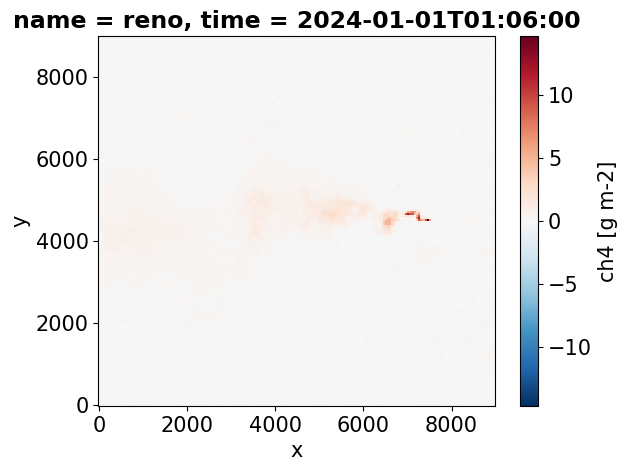

In [5]:
ds_bright_homo['ch4'].plot()

In [6]:
# get the source loc (the pixel of highest value at the beginning)
arg_max = xr.open_mfdataset(data_dir+'delta_xch4_point_50m_EMIT_Xinjiang.nc')['ch4'].isel(time=1, name=sel_name).load().argmax(...)
y_emiss = arg_max['y'].item()
x_emiss = arg_max['x'].item()

## Get the plume mask

In [7]:
def _azimuth(point1, point2):
    # https://stackoverflow.com/a/66118219/7347925
    """azimuth between 2 points (interval 0 - 180)"""
    angle = np.arctan2(point2[0] - point1[0], point2[1] - point1[1])
    return np.degrees(angle) if angle > 0 else np.degrees(angle) + 180


def _dist(a, b):
    """distance between points"""
    return math.hypot(b[0] - a[0], b[1] - a[1])


def azimuth(mrr):
    """azimuth of minimum_rotated_rectangle"""
    if isinstance(mrr, Polygon):
        bbox = list(mrr.exterior.coords)
        axis1 = _dist(bbox[0], bbox[3])
        axis2 = _dist(bbox[0], bbox[1])

        if axis1 <= axis2:
            az = _azimuth(bbox[0], bbox[1])
        else:
            az = _azimuth(bbox[0], bbox[3])
    else:
        az = np.nan

    return az

In [8]:
def get_feature_mask(data, sigma_threshold=1, n_min_threshold=5):
    dxy = abs(data.y.diff('y')[0])

    trim_mean = trimmed_mean(data.stack(z=('y', 'x')).dropna('z'), (1e-3, 1e-3))
    trim_std = trimmed_std(data.stack(z=('y', 'x')).dropna('z'), (1e-3, 1e-3))
    thresholds = [trim_mean+2*trim_std, trim_mean+3*trim_std]
    # thresholds = [(data.mean() + 2*data.std()).values, (data.mean() + 3*data.std()).values]

    # detect features
    features = tobac.feature_detection_multithreshold(
        data,
        dxy, thresholds,
        position_threshold='extreme',
        n_min_threshold=n_min_threshold,
        sigma_threshold=sigma_threshold,
    )

    threshold_seg = [(data.mean() + 2*data.std()).values]

    if features is None:
        return np.nan, np.nan, np.nan
    else:
        masks, features_mask = tobac.segmentation_2D(
            features, data, dxy, threshold=threshold_seg, statistic={'feature_max': np.max})

        features_mask['feature'] = np.arange(1, len(features_mask)+1, 1)
        # keep masks of more than n_min_threshold pixels
        masks = masks.astype('int')
        mask_count = masks.groupby(masks).count()
        mask_count = mask_count.where(mask_count > n_min_threshold).dropna(masks.name).astype('int')
        mask_unique = mask_count.coords['segmentation_mask'].values
        masks = masks.where(np.isin(masks, mask_unique, 0))
        masks = masks.drop_vars(['time'])

        mask_count = masks.groupby(masks).count().astype('int')
        mask_unique = mask_count.coords['segmentation_mask'].values

        # Replace values in the DataArray with sequential numbers
        for index, value in enumerate(mask_unique):
            masks = xr.where(masks == value, index, masks)

        return thresholds, features_mask, masks

In [9]:
def select_connect_masks(masks, masks_dilation, gdf_polygon, y_target, x_target, az_max=30):
    # get the source label of original mask and dilation mask
    mask_target = masks[y_target, x_target].item()
    mask_dilation_target = masks_dilation[y_target, x_target].values

    # get the dilation mask which contains mask including the target
    mask_dilation_target = masks_dilation.where(masks_dilation == mask_dilation_target)

    # mask in the dilation mask
    masks_in_dilation = masks.where((masks > 0) & (mask_dilation_target > 0))

    # unique mask labels within the dilation mask
    connect_labels = np.unique(masks_in_dilation.data.flatten())

    # get the polygons inside the dilation mask which includes the target mask
    gdf_polygon_connect = gdf_polygon[gdf_polygon.index.isin(connect_labels)]

    # filter masks by azimuth difference < 30
    if len(gdf_polygon_connect) > 1:
        # more thane one masks inside the dilation mask
        # calculate polygon distance
        distance = gdf_polygon_connect.geometry.apply(
            lambda g: gdf_polygon_connect[gdf_polygon_connect.index == mask_target]['geometry'].distance(g, align=False))
        if distance.empty:
            return gdf_polygon_connect, masks_in_dilation
        else:
            gdf_polygon_connect['distance'] = distance
            # sort masks by distance
            gdf_polygon_connect.sort_values('distance', inplace=True)

            # calcualte differences of az
            gdf_polygon_connect.loc[:, 'az_diff'] = gdf_polygon_connect['az'].diff().abs().fillna(0)

            # Iterate through the DataFrame to drop rows where az_diff is higher than az_max
            index_name = gdf_polygon_connect.index.name
            gdf_polygon_connect = gdf_polygon_connect.reset_index()

            index = 0
            while index < len(gdf_polygon_connect) - 1:
                if (gdf_polygon_connect['az_diff'].iloc[index + 1] > az_max) & (gdf_polygon_connect['distance'].iloc[index+1] > 0):
                    gdf_polygon_connect = gdf_polygon_connect.drop(index + 1)
                    gdf_polygon_connect = gdf_polygon_connect.reset_index(drop=True)
                    gdf_polygon_connect['az_diff'] = gdf_polygon_connect['az'].diff().abs().fillna(0)
                else:
                    index += 1

            # Set the index back to the original index values
            gdf_polygon_connect = gdf_polygon_connect.set_index(index_name)

    return gdf_polygon_connect, masks_in_dilation

In [10]:
def create_mask(data, denoise_data, dist=180):
    denoise_data = denoise_data.squeeze()
    denoise_data = denoise_data.expand_dims(time=1)
    thresholds, features, masks = get_feature_mask(denoise_data)

    df_mask = masks.to_dataframe().reset_index()
    df_mask = df_mask[df_mask['segmentation_mask'] > 0]
    df_mask = df_mask[df_mask['segmentation_mask'].map(df_mask['segmentation_mask'].value_counts()).gt(5)]

    gdf_polygon = gpd.GeoDataFrame(geometry=df_mask.groupby('segmentation_mask')
                                   .apply(lambda g: Polygon(gpd.points_from_xy(g['x'], g['y'])))
                                   )

    gdf_polygon['mrrs'] = gdf_polygon.geometry.apply(lambda geom: geom.minimum_rotated_rectangle)
    gdf_polygon['az'] = gdf_polygon['mrrs'].apply(azimuth)
    gdf_polygon = gdf_polygon.dropna(how='any')

    # dilation the mask
    struct = scipy.ndimage.generate_binary_structure(2, 2)
    dxy = data.coords['y'].diff('y')[0]
    niter = int(dist/dxy)
    masks_dilation = masks.copy(deep=True, data=ndimage.binary_dilation(masks, iterations=niter,  structure=struct))
    masks_dilation = masks_dilation.where(masks.notnull())

    # Label connected components in the dilated array
    labeled_array, num_features = ndimage.label(masks_dilation)
    masks_dilation = masks.copy(deep=True, data=labeled_array)

    # get the feature closest to the source loc
    tree_feature = spatial.KDTree(np.c_[features['hdim_1'], features['hdim_2']])
    target_row = tree_feature.query([(y_emiss, x_emiss)])[1][0]
    y_feature = features['hdim_1'].iloc[target_row]
    x_feature = features['hdim_2'].iloc[target_row]

    gdf_polygon_connect, masks_in_dilation = select_connect_masks(
        masks, masks_dilation, gdf_polygon, y_target=y_feature, x_target=x_feature)

    connect_labels = gdf_polygon_connect.index
    connect_masks = masks_in_dilation.where(masks_in_dilation.isin(connect_labels)).values
    
    return data.copy(data=connect_masks)

In [11]:
connect_masks_bright_homo = create_mask(ds_bright_homo['ch4'], ds_bright_homo_denoise['delta_xch4'])
connect_masks_bright_hetero = create_mask(ds_bright_hetero['ch4'], ds_bright_hetero_denoise['delta_xch4'])
connect_masks_dark_hetero = create_mask(ds_dark_hetero['ch4'], ds_dark_hetero_denoise['delta_xch4'])

## Calibrations over different scenes

In [12]:
def read_csv(data_dir, loc_name, instrument='EMIT', emiss_type='area', emiss_limit='', wind='u10'):
    if instrument == 'EMIT':
        res = '50m'
    else:
        res = '25m'

    if len(emiss_limit) > 0:
        df_source = pd.read_csv(f'{data_dir}/delta_xch4_{emiss_type}_{emiss_limit}_{res}_{instrument}_{loc_name}_denoise_{wind}_source.csv')
        df_plume = pd.read_csv(f'{data_dir}/delta_xch4_{emiss_type}_{emiss_limit}_{res}_{instrument}_{loc_name}_denoise_{wind}_inplume.csv')
        df_domain = pd.read_csv(f'{data_dir}/delta_xch4_{emiss_type}_{emiss_limit}_{res}_{instrument}_{loc_name}_denoise_{wind}_all.csv')
        df_crop_source = pd.read_csv(f'{data_dir}/delta_xch4_{emiss_type}_{emiss_limit}_{res}_{instrument}_{loc_name}_denoise_{wind}_source_2500m.csv')
        df_crop_plume = pd.read_csv(f'{data_dir}/delta_xch4_{emiss_type}_{emiss_limit}_{res}_{instrument}_{loc_name}_denoise_{wind}_inplume_2500m.csv')
        df_crop_domain = pd.read_csv(f'{data_dir}/delta_xch4_{emiss_type}_{emiss_limit}_{res}_{instrument}_{loc_name}_denoise_{wind}_all_2500m.csv')
        df_crop_source_1000 = pd.read_csv(f'{data_dir}/delta_xch4_{emiss_type}_{emiss_limit}_{res}_{instrument}_{loc_name}_denoise_{wind}_source_100m.csv')
        df_crop_plume_1000 = pd.read_csv(f'{data_dir}/delta_xch4_{emiss_type}_{emiss_limit}_{res}_{instrument}_{loc_name}_denoise_{wind}_inplume_1000m.csv')
        df_crop_domain_1000 = pd.read_csv(f'{data_dir}/delta_xch4_{emiss_type}_{emiss_limit}_{res}_{instrument}_{loc_name}_denoise_{wind}_all_1000m.csv')
    else:
        df_source = pd.read_csv(f'{data_dir}/delta_xch4_{emiss_type}_{res}_{instrument}_{loc_name}_denoise_{wind}_source.csv')
        df_plume = pd.read_csv(f'{data_dir}/delta_xch4_{emiss_type}_{res}_{instrument}_{loc_name}_denoise_{wind}_inplume.csv')
        df_domain = pd.read_csv(f'{data_dir}/delta_xch4_{emiss_type}_{res}_{instrument}_{loc_name}_denoise_{wind}_all.csv')
        df_crop_source = pd.read_csv(f'{data_dir}/delta_xch4_{emiss_type}_{res}_{instrument}_{loc_name}_denoise_{wind}_source_2500m.csv')
        df_crop_plume = pd.read_csv(f'{data_dir}/delta_xch4_{emiss_type}_{res}_{instrument}_{loc_name}_denoise_{wind}_inplume_2500m.csv')
        df_crop_domain = pd.read_csv(f'{data_dir}/delta_xch4_{emiss_type}_{res}_{instrument}_{loc_name}_denoise_{wind}_all_2500m.csv')
        df_crop_source_1000 = pd.read_csv(f'{data_dir}/delta_xch4_{emiss_type}_{res}_{instrument}_{loc_name}_denoise_{wind}_source_1000m.csv')
        df_crop_plume_1000 = pd.read_csv(f'{data_dir}/delta_xch4_{emiss_type}_{res}_{instrument}_{loc_name}_denoise_{wind}_inplume_1000m.csv')
        df_crop_domain_1000 = pd.read_csv(f'{data_dir}/delta_xch4_{emiss_type}_{res}_{instrument}_{loc_name}_denoise_{wind}_all_1000m.csv')

    return [df_source, df_plume, df_domain, df_crop_source, df_crop_plume, df_crop_domain, df_crop_source_1000, df_crop_plume_1000, df_crop_domain_1000]

In [13]:
def fit_line(x, y, fit_intercept=True, return_mask=False):
    from sklearn.linear_model import HuberRegressor, LinearRegression
    from sklearn.metrics import mean_squared_error
    # Reshape the arrays to 2D
    x_2d = x.reshape(-1, 1)
    y_2d = y.reshape(-1, 1)

    # # Create and fit the linear regression model
    # model = LinearRegression(fit_intercept=True)
    # model.fit(x_2d, y_2d)
    # # Get the slope of the linear regression line
    # slope = model.coef_[0][0]
    # intercept = model.intercept_[0]
    # # Calculate R-squared
    # r_squared = model.score(x_2d, y_2d)
    
    # Create the HuberRegressor
    huber = HuberRegressor(fit_intercept=fit_intercept)
    huber.fit(x_2d, y_2d)
    slope = huber.coef_[0]
    intercept = huber.intercept_


    # Calculate R-squared
    # r_squared = huber.score(x_2d, y_2d)
    
    r_squared = huber.score(x[~huber.outliers_].reshape(-1, 1), y[~huber.outliers_].reshape(-1, 1))

    mean_resid = np.mean(y - (slope*x+intercept))

    if return_mask:
        return slope, intercept, r_squared, mean_resid, ~huber.outliers_
    else:
        return slope, intercept, r_squared, mean_resid

In [14]:
def plot_regression_ime(df, xname, yname, color, name, ax=None, fit_intercept=True, plot=True):
    x = df[xname].values
    y = df[yname].values
    slope, intercept, r_squared, mean_resid = fit_line(x, y, fit_intercept)
    # print(name)
    # print(slope, intercept, r_squared, mean_resid)
    if plot:
        df.plot.scatter(ax=ax, x=xname, y=yname, c='None', ec=color)
        if intercept != 0:
            ax.axline((0, intercept), slope=slope,
                          label=f'{name} \n U$_{{eff}}$ = {slope:.2f}x + {intercept:.2f} (R$^2$ = {r_squared:.2f})', c=color)
        else:
            ax.axline((0, intercept), slope=slope,
                          label=f'{name} \n U$_{{eff}}$ = {slope:.2f}x (R$^2$ = {r_squared:.2f})', c=color)
    else:
        return pd.DataFrame({'slope': slope,
                             'intercept': intercept,
                             'r_squared': r_squared,
                             'mean_resid': mean_resid,
                            }, index=[0])

In [15]:
def plot_res(df_list, ax, method='ime', fit_intercept=True):
    plot_regression_ime(df_list[0].dropna(subset=[f'u10_{method}']), f'u10_{method}', f'ueff_{method}', 'grey', 'mean on-site wspd', ax, fit_intercept)
    plot_regression_ime(df_list[1].dropna(subset=[f'u10_{method}']), f'u10_{method}', f'ueff_{method}', 'C0', 'mean in-plume wspd', ax, fit_intercept)
    plot_regression_ime(df_list[2].dropna(subset=[f'u10_{method}']), f'u10_{method}', f'ueff_{method}', 'tomato', 'mean in-domain wspd', ax, fit_intercept)

In [16]:
def read_plot_data(axs, instrument, data_dir, emiss_type, emiss_limit='', method='ime', fit_intercept=True, wind='u10'):
    df_bright_homo_list = read_csv(data_dir=data_dir, loc_name='Xinjiang', emiss_type=emiss_type, emiss_limit=emiss_limit, instrument=instrument, wind=wind)
    df_bright_hetero_list = read_csv(data_dir=data_dir, loc_name='Anna_Creek', emiss_type=emiss_type, emiss_limit=emiss_limit, instrument=instrument, wind=wind)
    df_dark_hetero_list = read_csv(data_dir=data_dir, loc_name='Madrid', emiss_type=emiss_type, emiss_limit=emiss_limit, instrument=instrument, wind=wind)
    
    plot_res(df_bright_homo_list, axs[0], method, fit_intercept)
    axs[0].set_title('bright, homogeneous')
    
    plot_res(df_bright_hetero_list, axs[1], method, fit_intercept)
    axs[1].set_title('bright, heterogeneous')
    
    plot_res(df_dark_hetero_list, axs[2], method, fit_intercept)
    axs[2].set_title('dark, heterogeneous')
    
    for ax in axs:
        ax.set_xlim(0.5, 5)
        ax.set_ylim(0.5, 5)
        ax.legend(loc="upper left")

    # plt.suptitle(instrument+' ('+emiss_type+' source)')

## Summary

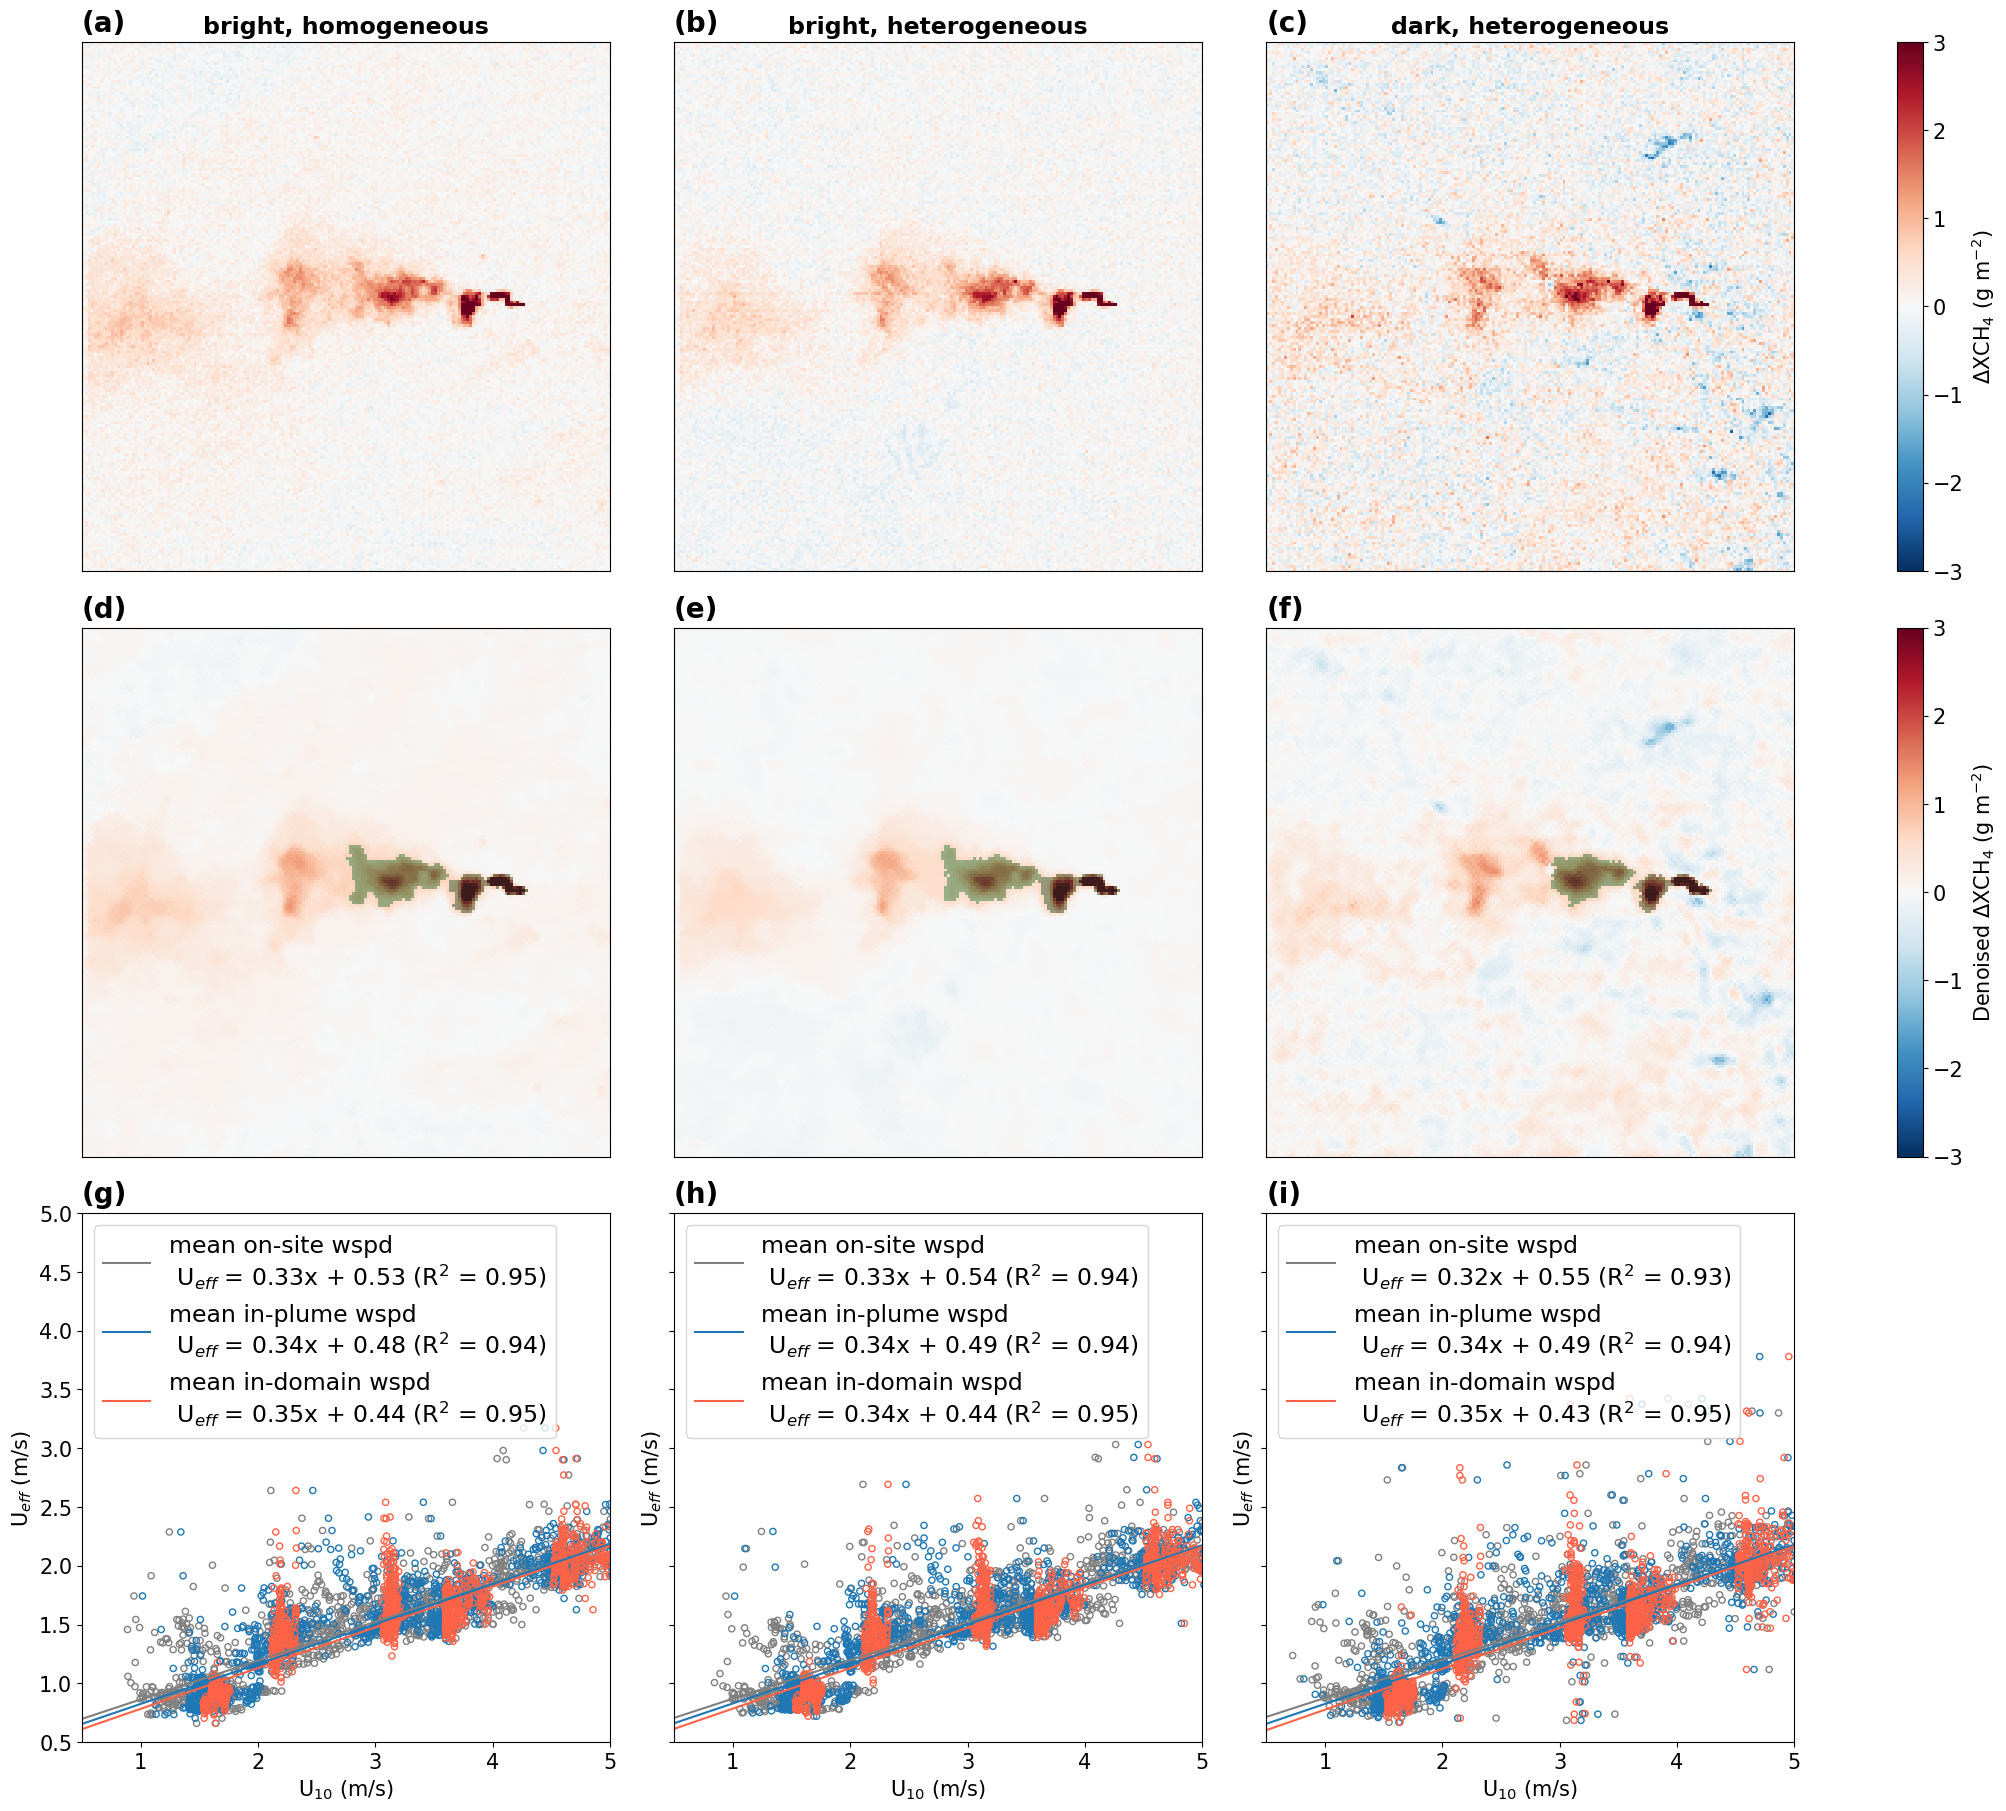

In [17]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(20, 18), constrained_layout=True)


ds_bright_homo['ch4'].plot(ax=axs[0, 0], vmin=-3, vmax=3, cmap='RdBu_r', add_colorbar=False, rasterized=True)
ds_bright_hetero['ch4'].plot(ax=axs[0, 1], vmin=-3, vmax=3, cmap='RdBu_r', add_colorbar=False, rasterized=True)
m1 = ds_dark_hetero['ch4'].plot(ax=axs[0, 2], vmin=-3, vmax=3, cmap='RdBu_r', add_colorbar=False, rasterized=True)

ds_bright_homo_denoise['delta_xch4'].plot(ax=axs[1, 0], vmin=-3, vmax=3, cmap='RdBu_r', add_colorbar=False, rasterized=True)
ds_bright_hetero_denoise['delta_xch4'].plot(ax=axs[1, 1], vmin=-3, vmax=3, cmap='RdBu_r', add_colorbar=False, rasterized=True)
m2 = ds_dark_hetero_denoise['delta_xch4'].plot(ax=axs[1, 2], vmin=-3, vmax=3, cmap='RdBu_r', add_colorbar=False, rasterized=True)

axs[0, 0].set_title('bright, homogeneous')
axs[0, 1].set_title('bright, heterogeneous')
axs[0, 2].set_title('dark, heterogeneous')

fig.colorbar(m1, ax=axs[0, :], label='$\Delta$XCH$_4$ (g m$^{-2}$)')
fig.colorbar(m2, ax=axs[1, :], label='Denoised $\Delta$XCH$_4$ (g m$^{-2}$)')

connect_masks_bright_homo.plot(ax=axs[1, 0], cmap='Greens_r', vmax=10, alpha=0.4, add_colorbar=False)
connect_masks_bright_hetero.plot(ax=axs[1, 1], cmap='Greens_r', vmax=10, alpha=0.4, add_colorbar=False)
connect_masks_dark_hetero.plot(ax=axs[1, 2], cmap='Greens_r', vmax=10, alpha=0.4, add_colorbar=False)

read_plot_data(axs=axs[2:, :].flatten(), instrument='EMIT', data_dir=data_dir, emiss_type='point')

for ax in axs[1:, :].flatten():
    ax.set_title('')

for ax in axs[:2, :].flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

for ax in axs[2:, :].flatten():
    ax.set_xlabel('U$_{10}$ (m/s)')
    ax.set_ylabel('U$_{eff}$ (m/s)')
    
for ax in [axs[2, 1], axs[2, 2]]:
#     ax.set_ylabel('')
#     ax.set_yticklabels([])
    
# for ax in axs[1:]:
    ax.tick_params('y', labelleft=False)

for n, ax in enumerate(axs.flatten()):
    ax.text(0, 1.02, '({})'.format(string.ascii_lowercase[n]),
            transform=ax.transAxes, 
            size=20, weight='bold')

fig.savefig('../figures/scene_calib.pdf', bbox_inches='tight')